In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import warnings 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import *
warnings.filterwarnings("ignore")
# import statistic library
from scipy import stats
import statsmodels.api as sm
import scipy.cluster.hierarchy as sch

In [30]:
data = pd.read_csv("Dataset/processed_data.csv")

### RFM Analysis

Recency, Frequency, Monetary Value (RFM) analysis method is a method of customer analysis and segmentation based on customer habits. The variables used to perform RFM analysis are:

- Recency: How recently the customer made a transaction.
- Frequency: How often customers make transactions
- Monetary: How many transactions the customer has made

1. Recency: The difference between the last day the customer made a transaction and the day he did the analysis. In this case, the day of analysis uses the data of the last day of the transaction.
2. Frequency: The number of transactions made by customers 
3. Monetary: Total order amount issued by customers 

***Here are the steps in creating an RFM model:***

* Calculate RFM Value
* Calculate RFM Score
* Calculate the total RFM score
* Labeling

#### RFM Value

Receny Value

In [31]:
rfm_table1 = pd.DataFrame(data['CustomerID'].unique())
rfm_table1.columns = ['CustomerID']
rfm_table1.head()

,CustomerID
0,15974.0
1,15632.0
2,15406.0
3,14495.0
4,14499.0


In [32]:
# the latest purchase for every customer
latest_purchase = data.groupby('CustomerID').InvoiceDate.max().reset_index()
latest_purchase.columns = ['CustomerID','LatestPurchaseDate']

In [33]:
latest_purchase['LatestPurchaseDate'] = pd.to_datetime(latest_purchase['LatestPurchaseDate'])

In [34]:
# Calculate Recency
# Recency = point in time of observation - number of days last purchase
latest_purchase['Recency'] = (latest_purchase['LatestPurchaseDate'].max() - latest_purchase['LatestPurchaseDate']).dt.days
latest_purchase.head()

,CustomerID,LatestPurchaseDate,Recency
0,12347.0,2011-12-07 15:52:00,1
1,12349.0,2011-11-21 09:51:00,18
2,12350.0,2011-02-02 16:01:00,309
3,12352.0,2011-11-03 14:37:00,35
4,12354.0,2011-04-21 13:11:00,231


In [35]:
latest_purchase.head()

,CustomerID,LatestPurchaseDate,Recency
0,12347.0,2011-12-07 15:52:00,1
1,12349.0,2011-11-21 09:51:00,18
2,12350.0,2011-02-02 16:01:00,309
3,12352.0,2011-11-03 14:37:00,35
4,12354.0,2011-04-21 13:11:00,231


In [36]:
rfm_table1 = pd.merge(rfm_table1, latest_purchase[['CustomerID','Recency']], on='CustomerID')
rfm_table1.head()

,CustomerID,Recency
0,15974.0,38
1,15632.0,15
2,15406.0,30
3,14495.0,50
4,14499.0,25


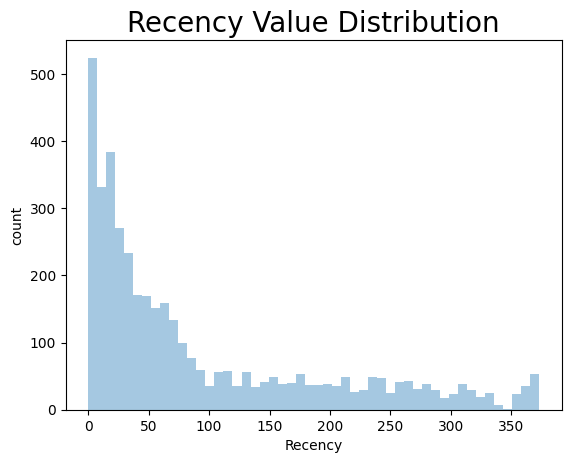

In [37]:
# Recency value distribution
sns.distplot(rfm_table1['Recency'], kde=False, bins=50)
plt.title('Recency Value Distribution', fontsize = 20)
plt.xlabel('Recency')
plt.ylabel('count');

#### Frequency

In [38]:
# Calculate Frequency
frequency = data.groupby('CustomerID').InvoiceDate.count().reset_index()
frequency.columns = ['CustomerID','frequency']
frequency.head()

,CustomerID,frequency
0,12347.0,47
1,12349.0,19
2,12350.0,6
3,12352.0,31
4,12354.0,13


In [39]:
rfm_table1 = pd.merge(rfm_table1,frequency, on='CustomerID')
rfm_table1

,CustomerID,Recency,frequency
0,15974.0,38,55
1,15632.0,15,56
2,15406.0,30,19
3,14495.0,50,2
4,14499.0,25,67
...,...,...,...
4081,14477.0,50,1
4082,13260.0,60,1
4083,17879.0,173,1
4084,14785.0,14,1


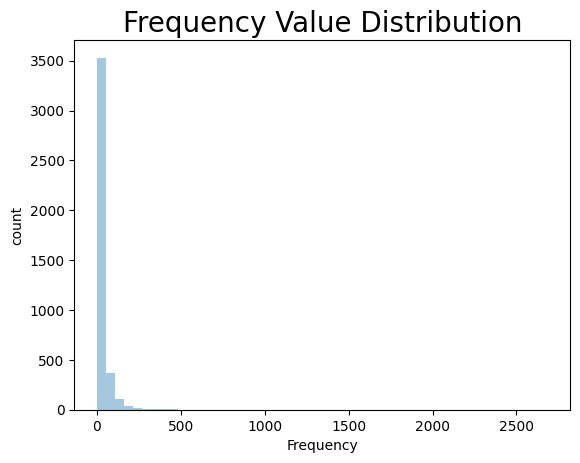

In [40]:
# Frequency Value Distribution
sns.distplot(rfm_table1['frequency'], kde=False, bins=50)
plt.title('Frequency Value Distribution', fontsize = 20)
plt.xlabel('Frequency')
plt.ylabel('count');

#### Monetary

In [41]:
# Calculate Monetary
monetary = data.groupby('CustomerID').Revenue.sum().reset_index()
monetary.columns = ['CustomerID','monetary']
monetary.head()

,CustomerID,monetary
0,12347.0,971.65
1,12349.0,352.78
2,12350.0,125.40
3,12352.0,513.66
4,12354.0,202.60


In [42]:
rfm_table1 = pd.merge(rfm_table1, monetary, on='CustomerID')
rfm_table1.head()

,CustomerID,Recency,frequency,monetary
0,15974.0,38,55,944.43
1,15632.0,15,56,1126.55
2,15406.0,30,19,120.69
3,14495.0,50,2,41.60
4,14499.0,25,67,280.39


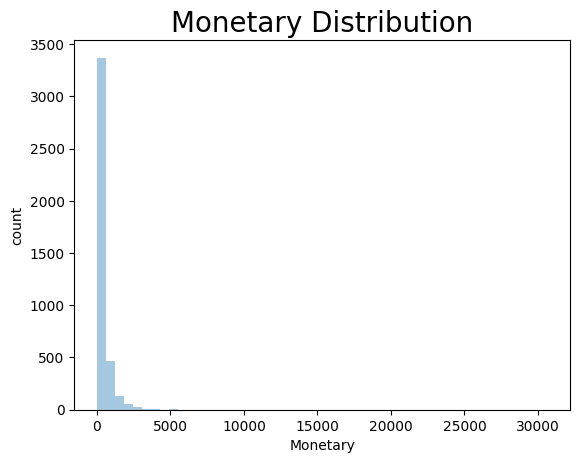

In [43]:
# Monetary Value Distribution
sns.distplot(rfm_table1['monetary'], kde=False, bins=50)
plt.title('Monetary Distribution', fontsize = 20)
plt.xlabel('Monetary')
plt.ylabel('count');

#### 2. RFM Score

- The calculation of the individual RFM Score can be done using the Quartile statistical method (dividing the Score into four parts).

The steps is:

1. Split the metrics into segments using quantiles.
2. We assign a score from 1 to 4 to Recency, Frequency and Monetary.
3. Four is the best/highest value, and one is the lowest/worst value.

In [44]:
quartiles = rfm_table1.quantile(q=[0.25, 0.5, 0.75])
quartiles

,CustomerID,Recency,frequency,monetary
0.25,13808.25,17.0,6.0,79.235
0.50,15288.50,51.0,14.0,178.955
0.75,16765.50,148.0,33.0,430.510


In [45]:
segmented_rfm1 = rfm_table1.copy()

In [46]:
def recency_score (data):
    if data <= 15:
        return 4
    elif data <= 47:
        return 3
    elif data <= 135:
        return 2
    else:
        return 1

def frequency_score (data):
    if data <= 16:
        return 1
    elif data <= 38:
        return 2
    elif data <= 87:
        return 3
    else:
        return 4
def monetary_value_score (data):
    if data <= 219.9525:
        return 1
    elif data <= 489.5500:
        return 2
    elif data <= 1183.5400:
        return 3
    else:
        return 4

segmented_rfm1['R'] = segmented_rfm1['Recency'].apply(recency_score )
segmented_rfm1['F'] = segmented_rfm1['frequency'].apply(frequency_score)
segmented_rfm1['M'] = segmented_rfm1['monetary'].apply(monetary_value_score)
segmented_rfm1.head()

,CustomerID,Recency,frequency,monetary,R,F,M
0,15974.0,38,55,944.43,3,3,3
1,15632.0,15,56,1126.55,4,3,3
2,15406.0,30,19,120.69,3,2,1
3,14495.0,50,2,41.60,2,1,1
4,14499.0,25,67,280.39,3,3,2


- Best Recency score = 4: purchased very recently.
- Best Frequency score = 4: highest quantity purchases.
- Best Monetary score = 4: spent the most.

#### 3.Total RFM Score

In [47]:
segmented_rfm1['RFM_score'] =segmented_rfm1[['R', 'F', 'M']].sum(axis=1)

,CustomerID,Recency,frequency,monetary,R,F,M,RFM_score
0,15974.0,38,55,944.43,3,3,3,9
1,15632.0,15,56,1126.55,4,3,3,10
2,15406.0,30,19,120.69,3,2,1,6
3,14495.0,50,2,41.60,2,1,1,4
4,14499.0,25,67,280.39,3,3,2,8


In [49]:
segmented_rfm1['RFM_Segment'] = segmented_rfm1.R.map(str)+segmented_rfm1.F.map(str)+segmented_rfm1.M.map(str)
segmented_rfm1.head()

,CustomerID,Recency,frequency,monetary,R,F,M,RFM_score,RFM_Segment
0,15974.0,38,55,944.43,3,3,3,9,333
1,15632.0,15,56,1126.55,4,3,3,10,433
2,15406.0,30,19,120.69,3,2,1,6,321
3,14495.0,50,2,41.60,2,1,1,4,211
4,14499.0,25,67,280.39,3,3,2,8,332


#### 4. Labelling

In [50]:
# Setting up the label for each client and adding the column "Label" to the dataframe

label = [0] * len(segmented_rfm1)

for i in range(0,len(segmented_rfm1)):

    if segmented_rfm1['RFM_Segment'][i] == '444':
        label[i] = "Best Customers"
        
    elif segmented_rfm1['RFM_Segment'][i] == '334'or segmented_rfm1['RFM_Segment'][i] == '441'or segmented_rfm1['RFM_Segment'][i] == '442'or segmented_rfm1['RFM_Segment'][i] == '244'or segmented_rfm1['RFM_Segment'][i] == '343'or segmented_rfm1['RFM_Segment'][i] == '344'or segmented_rfm1['RFM_Segment'][i] == '433'or segmented_rfm1['RFM_Segment'][i] == '434'or segmented_rfm1['RFM_Segment'][i] == '443':
        label[i] = "Loyal Custumers"
        
    elif segmented_rfm1['RFM_Segment'][i] == '311'or segmented_rfm1['RFM_Segment'][i] == '324'or segmented_rfm1['RFM_Segment'][i] == '341'or segmented_rfm1['RFM_Segment'][i] == '342'or segmented_rfm1['RFM_Segment'][i] == '314'or segmented_rfm1['RFM_Segment'][i] == '414'or segmented_rfm1['RFM_Segment'][i] == '424'or segmented_rfm1['RFM_Segment'][i] == '312' or segmented_rfm1['RFM_Segment'][i] == '313' or segmented_rfm1['RFM_Segment'][i] == '321'or segmented_rfm1['RFM_Segment'][i] == '322'or segmented_rfm1['RFM_Segment'][i] == '323'or segmented_rfm1['RFM_Segment'][i] == '331'or segmented_rfm1['RFM_Segment'][i] == '332'or segmented_rfm1['RFM_Segment'][i] == '333'or segmented_rfm1['RFM_Segment'][i] == '411'or segmented_rfm1['RFM_Segment'][i] == '412'or segmented_rfm1['RFM_Segment'][i] == '413'or segmented_rfm1['RFM_Segment'][i] == '421'or segmented_rfm1['RFM_Segment'][i] == '422'or segmented_rfm1['RFM_Segment'][i] == '423'or segmented_rfm1['RFM_Segment'][i] == '431'or segmented_rfm1['RFM_Segment'][i] == '432':
        label[i] = "Potential Costumers"

    elif segmented_rfm1['RFM_Segment'][i] == '222'or segmented_rfm1['RFM_Segment'][i] == '223'or segmented_rfm1['RFM_Segment'][i] == '232'or segmented_rfm1['RFM_Segment'][i] == '233'or segmented_rfm1['RFM_Segment'][i] == '113'or segmented_rfm1['RFM_Segment'][i] == '114'or segmented_rfm1['RFM_Segment'][i] == '131'or segmented_rfm1['RFM_Segment'][i] == '141'or segmented_rfm1['RFM_Segment'][i] == '213'or segmented_rfm1['RFM_Segment'][i] == '214'or segmented_rfm1['RFM_Segment'][i] == '231'or segmented_rfm1['RFM_Segment'][i] == '214'or segmented_rfm1['RFM_Segment'][i] == '231'or segmented_rfm1['RFM_Segment'][i] == '241'or segmented_rfm1['RFM_Segment'][i] == '243':
        label[i] = "Customers Needing Attention"
    
    elif segmented_rfm1['RFM_Segment'][i] == '144'or segmented_rfm1['RFM_Segment'][i] == '244'or segmented_rfm1['RFM_Segment'][i] == '143'or segmented_rfm1['RFM_Segment'][i] == '134':
        label[i] = "Cant' Lose Them"

    elif segmented_rfm1['RFM_Segment'][i] == '121'or segmented_rfm1['RFM_Segment'][i] == '122'or segmented_rfm1['RFM_Segment'][i] == '112'or segmented_rfm1['RFM_Segment'][i] == '212'or segmented_rfm1['RFM_Segment'][i] == '211'or segmented_rfm1['RFM_Segment'][i] == '221'or segmented_rfm1['RFM_Segment'][i] == '222'or segmented_rfm1['RFM_Segment'][i] == '123'or segmented_rfm1['RFM_Segment'][i] == '124'or segmented_rfm1['RFM_Segment'][i] == '132'or segmented_rfm1['RFM_Segment'][i] == '133'or segmented_rfm1['RFM_Segment'][i] == '134'or segmented_rfm1['RFM_Segment'][i] == '142'or segmented_rfm1['RFM_Segment'][i] == '224'or segmented_rfm1['RFM_Segment'][i] == '242':
        label[i] = "At Risk Customers"

    elif segmented_rfm1['RFM_Segment'][i] == '111':
        label[i] = "Lost Customers"
        
    else:
        label[i] = "Others"

In [51]:
segmented_rfm1['label'] = label
segmented_rfm1

,CustomerID,Recency,frequency,monetary,R,F,M,RFM_score,RFM_Segment,label
0,15974.0,38,55,944.43,3,3,3,9,333,Potential Costumers
1,15632.0,15,56,1126.55,4,3,3,10,433,Loyal Custumers
2,15406.0,30,19,120.69,3,2,1,6,321,Potential Costumers
3,14495.0,50,2,41.60,2,1,1,4,211,At Risk Customers
4,14499.0,25,67,280.39,3,3,2,8,332,Potential Costumers
...,...,...,...,...,...,...,...,...,...,...
4081,14477.0,50,1,41.60,2,1,1,4,211,At Risk Customers
4082,13260.0,60,1,19.80,2,1,1,4,211,At Risk Customers
4083,17879.0,173,1,129.36,1,1,1,3,111,Lost Customers
4084,14785.0,14,1,9.48,4,1,1,6,411,Potential Costumers


In [52]:
# Count the frequency that a value occurs in a dataframe column for the labels.
segmented_rfm1['label'].value_counts()

Potential Costumers            1513
At Risk Customers               938
Lost Customers                  843
Loyal Custumers                 336
Customers Needing Attention     329
Best Customers                  119
Others                            5
Cant' Lose Them                   3
Name: label, dtype: int64

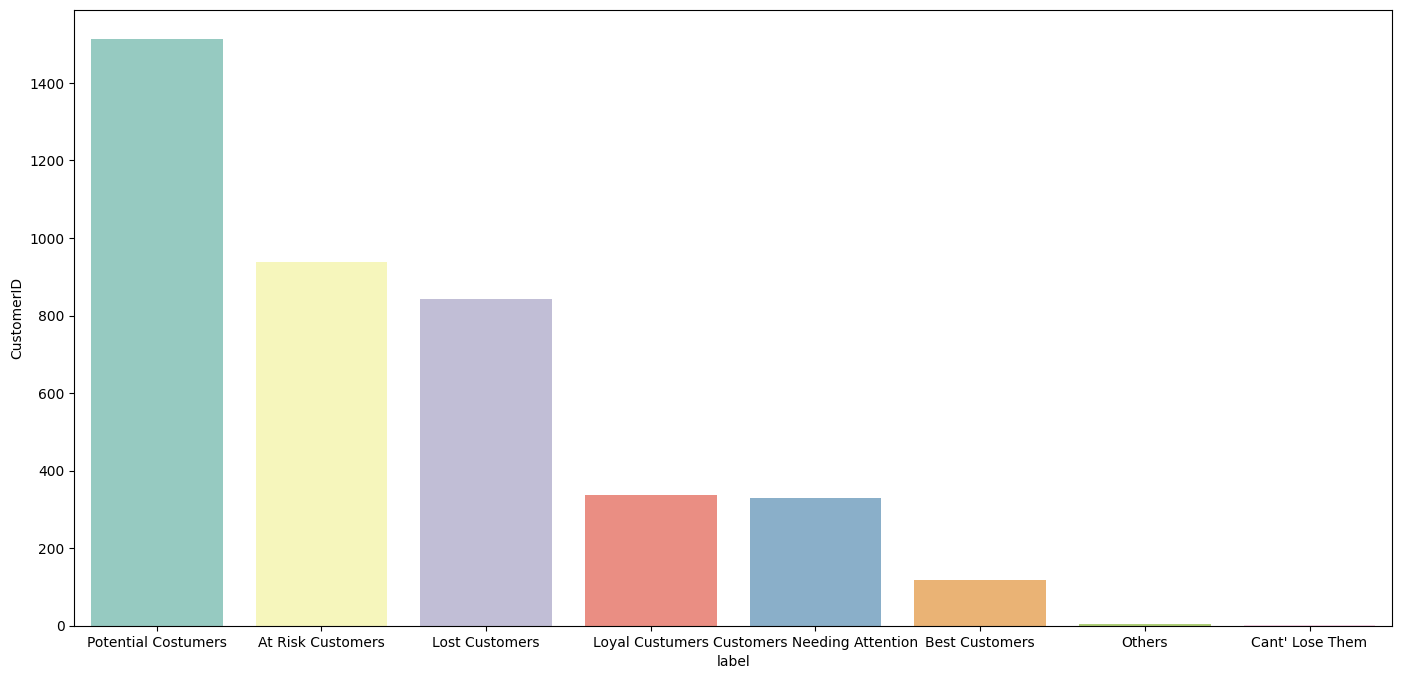

In [54]:
segmentation1=segmented_rfm1.groupby('label')['CustomerID'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(17,8))
segmentation1.drop([0],inplace=False)
sns.barplot(data=segmentation1, x="label", y="CustomerID", palette = "Set3");

## K-Means Clustering

We have segmented customers based on RFM values to make a different and optimal approach with the Quantile Method. However, this RFM segmentation process can also be done by scoring or the original value using Machine Learning techniques.

Machine learning methods can be used for segmentation and are familiarly known as Unsupervised Machine Learning. The Unsupervised Machine Learning approach will study data patterns and then group each data into unique clusters.

K-Means clustering algorithm is an unsupervised machine learning algorithm that uses multiple iterations to segment the unlabeled data points into K different clusters in a way such that each data point belongs to only a single group that has similar properties.

In [55]:
# create Dataframe new_rfm1 
new_rfm1 = rfm_table1.drop('CustomerID', axis=1)
new_rfm1.head()

,Recency,frequency,monetary
0,38,55,944.43
1,15,56,1126.55
2,30,19,120.69
3,50,2,41.60
4,25,67,280.39


K-means gives the best result under the following conditions:

- Data’s distribution is not skewed.
- Data is standardised (i.e. mean of 0 and standard deviation of 1).

In [56]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 1.2147861560748336, : SkewtestResult(statistic=25.37982710763498, pvalue=4.212173171797376e-142)
frequency's: Skew: 18.67752345309405, : SkewtestResult(statistic=81.78687938565663, pvalue=0.0)
monetary's: Skew: 16.84924355268436, : SkewtestResult(statistic=79.58419538974653, pvalue=0.0)


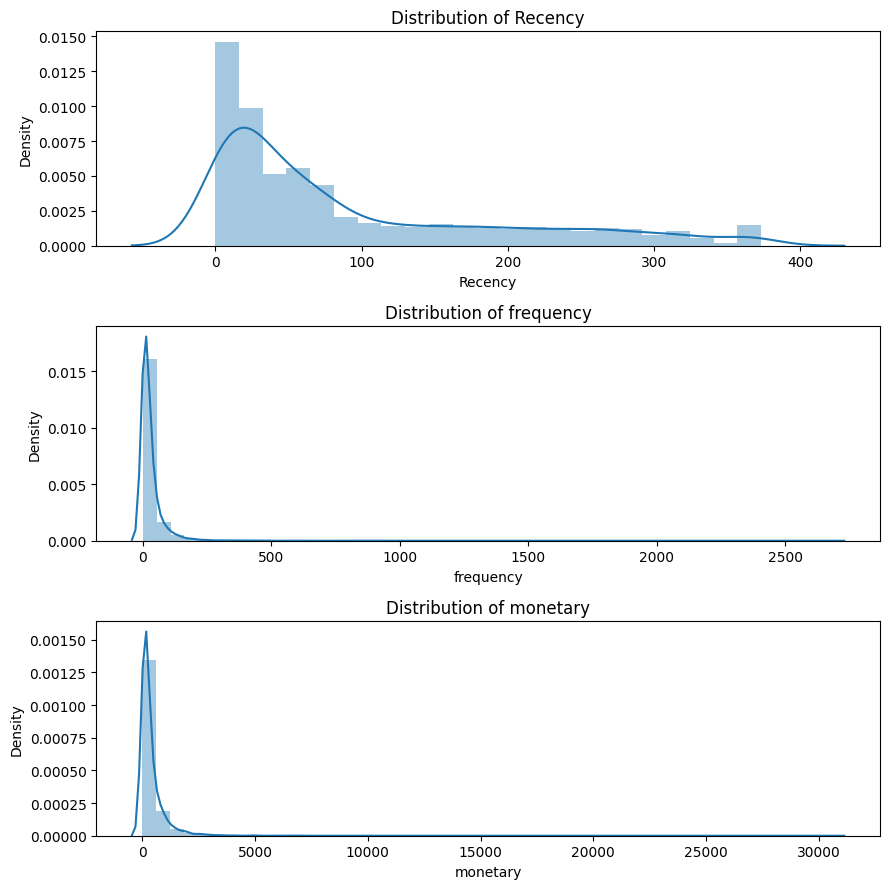

In [61]:

# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(new_rfm1,'Recency')

plt.subplot(3, 1, 2)
check_skew(new_rfm1,'frequency')

plt.subplot(3, 1, 3)
check_skew(new_rfm1,'monetary')

plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)

In [63]:
df_rfm_log = new_rfm1.copy()

Recency's: Skew: -0.5774895836015775, : SkewtestResult(statistic=-14.063758986007679, pvalue=6.342574136588407e-45)
frequency's: Skew: 0.2577992141689392, : SkewtestResult(statistic=6.63314160339901, pvalue=3.286162733157375e-11)
monetary's: Skew: -0.05938807697091858, : SkewtestResult(statistic=-1.5512638011103463, pvalue=0.12083847797440772)


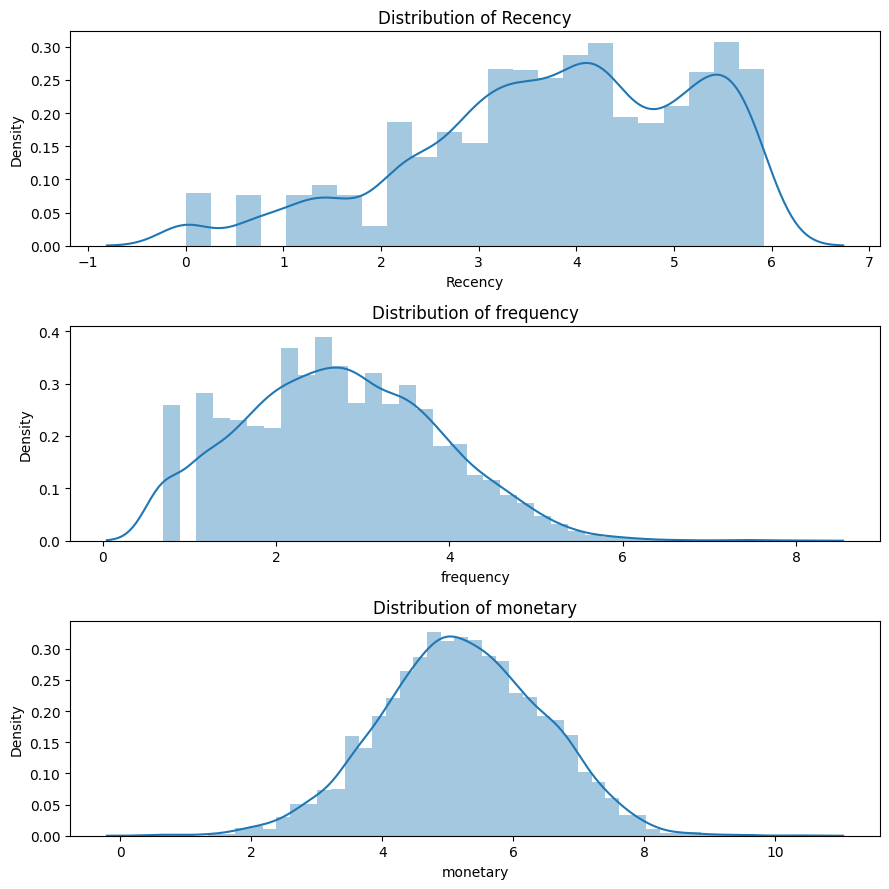

In [64]:
df_rfm_log = np.log(df_rfm_log+1)
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'frequency')

plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'monetary')

plt.tight_layout()
plt.savefig('after_transform.png', format='png', dpi=1000)

In [67]:
scaler = StandardScaler()
scaler.fit(df_rfm_log)
RFM_scaled1 = scaler.transform(df_rfm_log)

In [68]:
RFM_scaled1 = pd.DataFrame(RFM_scaled1, columns=df_rfm_log.columns)
RFM_scaled1

,Recency,frequency,monetary
0,-0.093655,1.134895,1.325978
1,-0.720331,1.150509,1.468355
2,-0.255129,0.226565,-0.330991
3,0.095031,-1.447074,-1.179310
4,-0.378843,1.306179,0.346506
...,...,...,...
4081,0.095031,-1.804776,-1.179310
4082,0.220967,-1.804776,-1.758719
4083,0.958217,-1.804776,-0.275367
4084,-0.765724,-1.804776,-2.312737


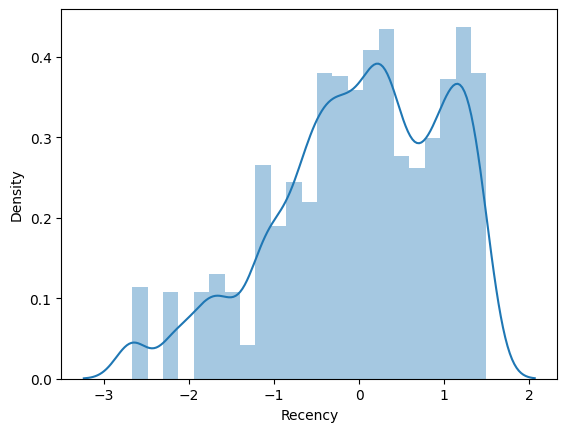

In [70]:
#Analyze distribution
sns.distplot(RFM_scaled1['Recency']);

#### Finding the optimal number of clusters

In [71]:
X = np.asarray(RFM_scaled1)

In [74]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_scaled1) 
    kmeanModel.fit(RFM_scaled1)     
      
    distortions.append(sum(np.min(cdist(RFM_scaled1, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_scaled1.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_scaled1, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_scaled1.shape[0] 
    mapping2[k] = kmeanModel.inertia_

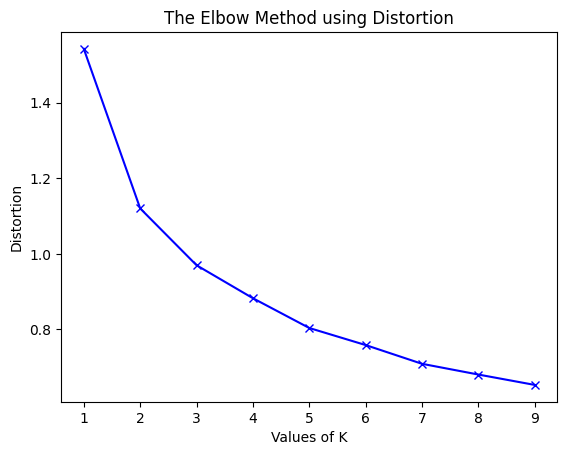

In [75]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

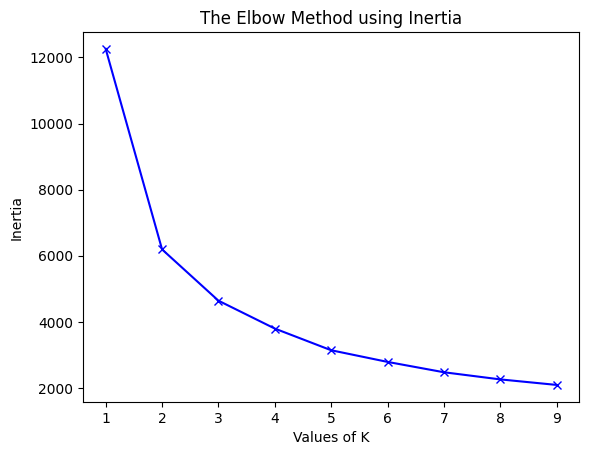

In [76]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

The cluster value where this decrease in distortion and inertia value becomes constant can be chosen as the right cluster value for our data. Looking at the above elbow curve, we can choose any number of clusters between 3 to 5.

In [77]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)
    # Extract cluster labels
    cluster_labels = kmeans.labels_
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    return df_new

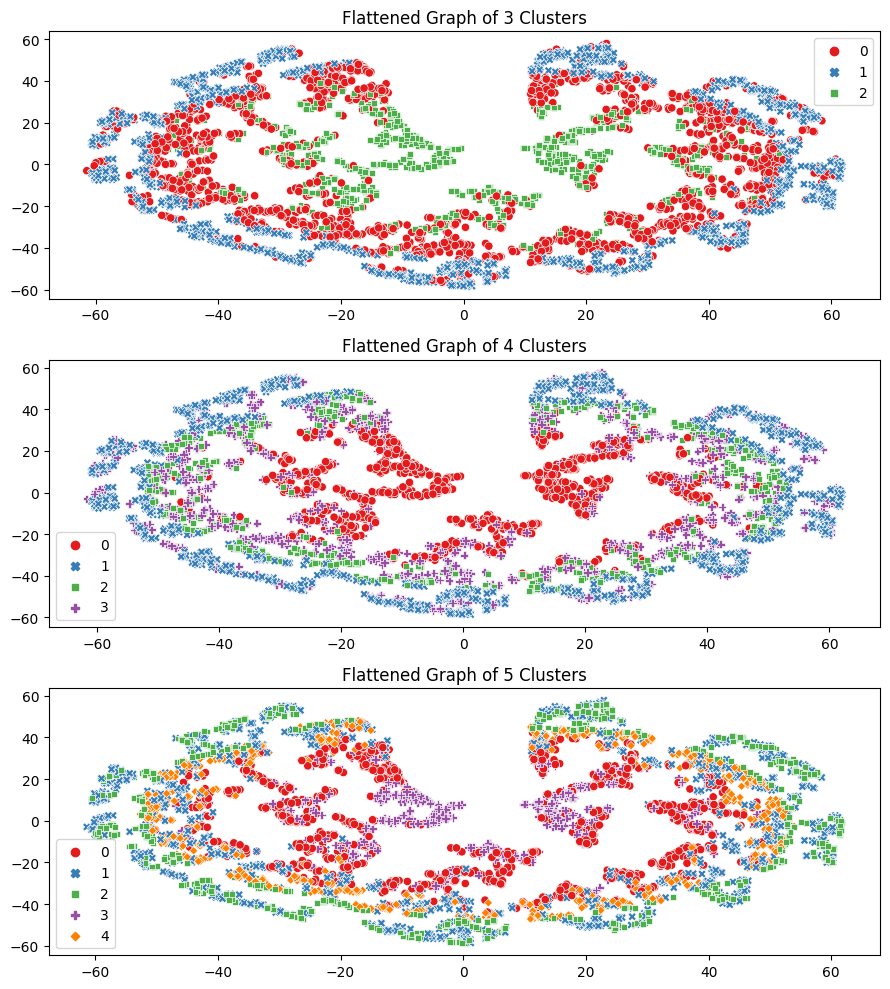

In [80]:
plt.figure(figsize=(9, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_scaled1, 3, rfm_table1)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_scaled1, 4, rfm_table1)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_scaled1, 5, rfm_table1)

plt.tight_layout()
plt.savefig('flattened.png', format='png', dpi=1000)

In [84]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=rfm_table1.index, 
                                       columns=rfm_table1.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'frequency', 'monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

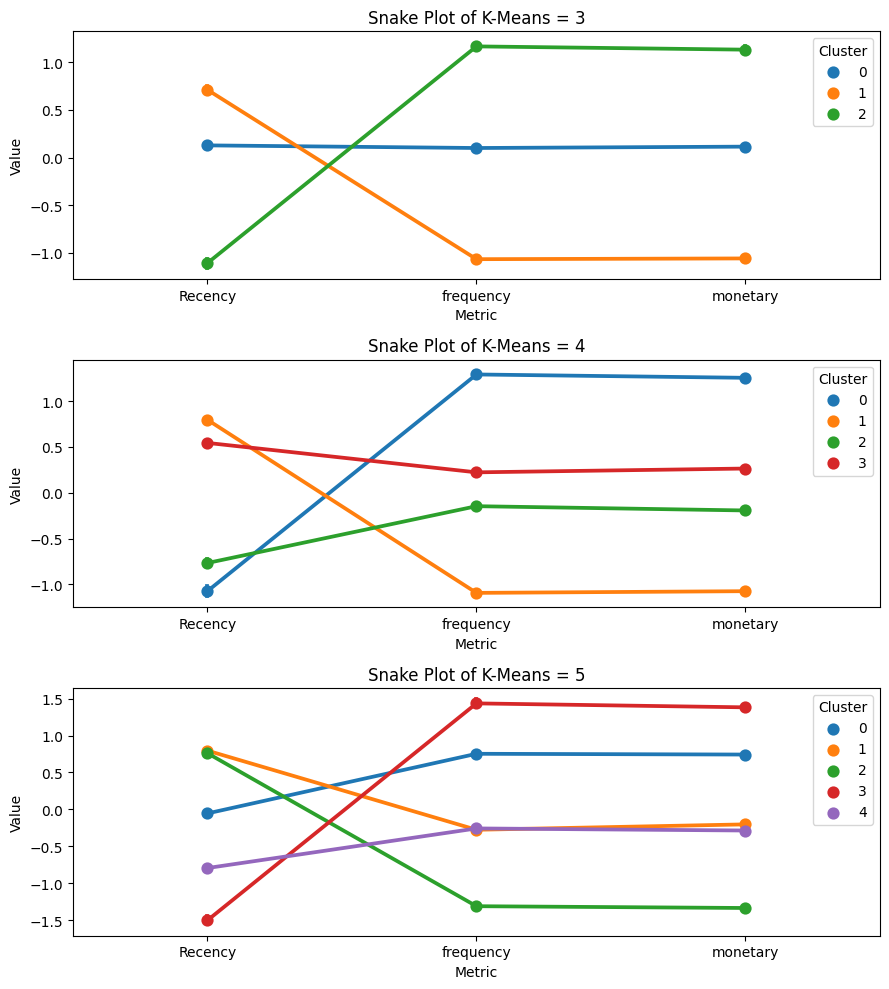

In [85]:
plt.figure(figsize=(9, 10))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_scaled1, df_rfm_k3, rfm_table1)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_scaled1, df_rfm_k4, rfm_table1)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_scaled1, df_rfm_k5, rfm_table1)

plt.tight_layout()


From the flattened graphs and the snake plots it is evident that having a cluster value of 4,segments our customers well. We could also go for higher number of clusters, it completely depends on how the company wants to segment their customers.

#### Evaluating Model
- Davies Bouldin Score

Davies Bouldin Score is a metric for evaluating clustering algorithms.

The smaller Davies Bouldin Score is The more optimal the cluster.

In [100]:
def optimal_cluster(n):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    print(f"Number of cluster {n}, Davies Bulding Score {davies_bouldin_score(X, kmeans.labels_)}")

optimal_cluster(3)

Number of cluster 3, Davies Bulding Score 1.0534665409278132


In [89]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
print(davies_bouldin_score(X, kmeans.labels_))

1.0267053761344056


In [90]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
print(davies_bouldin_score(X, kmeans.labels_))

1.0004863892665534


In [91]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
print(davies_bouldin_score(X, kmeans.labels_))

1.0114722078548575


#### Silhouetter Score
Silhoutter Score is a metric for evaluating clustering algorithms.

The higher Silhouuter Score is the more optimal the cluster.

In [102]:
def optimal_sil_Score(n):
    km = KMeans(n_clusters=n)
# Fit the KMeans model
    km.fit_predict(X)
# Calculate Silhoutte Score
    score = silhouette_score(X, km.labels_, metric='euclidean')
    print('Silhouetter Score: %.3f' % score)

optimal_sil_Score(3)

Silhouetter Score: 0.316


In [103]:
optimal_sil_Score(4)

Silhouetter Score: 0.315


In [104]:
optimal_sil_Score(5)

Silhouetter Score: 0.300


In [105]:
optimal_sil_Score(6)

Silhouetter Score: 0.293


K means with 3 cluster has higher silhoutter score than other clusters. therefore optimum cluster is 3

In [106]:
df_rfm_k3.head()

,CustomerID,Recency,frequency,monetary,Cluster
0,15974.0,38,55,944.43,2
1,15632.0,15,56,1126.55,2
2,15406.0,30,19,120.69,0
3,14495.0,50,2,41.60,1
4,14499.0,25,67,280.39,2


In [108]:
df_rfm_k3.Cluster.value_counts()

0    1761
1    1293
2    1032
Name: Cluster, dtype: int64

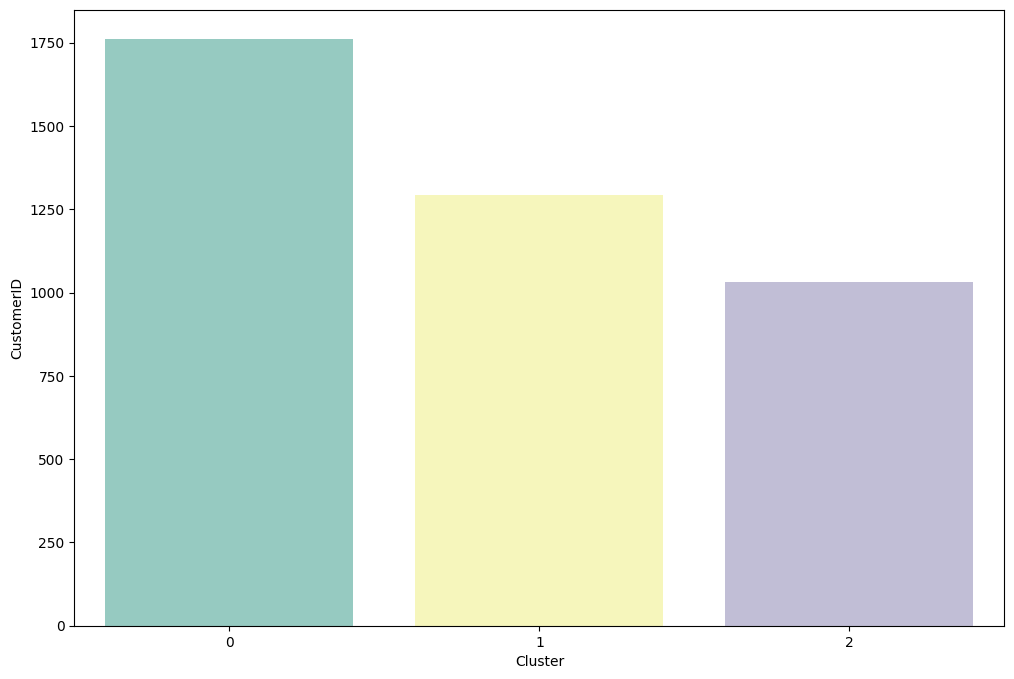

In [110]:
sq1=df_rfm_k3.groupby('Cluster')['CustomerID'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12,8))
sns.barplot(data=sq1, x="Cluster", y="CustomerID", palette = "Set3");

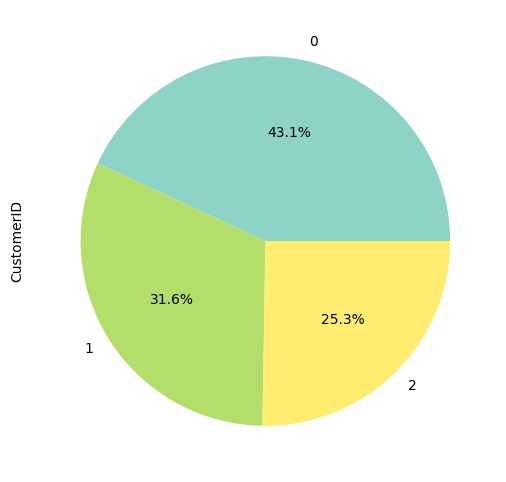

In [112]:

df_rfm_k3.groupby('Cluster')['CustomerID'].nunique().sort_values(ascending=False).plot(kind='pie',cmap='Set3',figsize=(6,6),autopct='%1.1f%%')
plt.show()

- cluster 0 has 43.1% customers.
- cluster 1 has 31.6% customers.
- cluster 2 has 25.3% customers.

In [113]:
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'frequency': 'mean',
        'monetary': ['mean']
    }).round(0)
    return df_new

In [114]:
rfm_values(df_rfm_k3).reset_index()

,Cluster,Recency,frequency,monetary
,,mean,mean,mean
0,0,82.0,20.0,254.0
1,1,170.0,4.0,61.0
2,2,15.0,81.0,1030.0


In [125]:
# Cluster 0
Cluster0=recency_score(82),frequency_score(20),monetary_value_score(254)
print(Cluster0,'Customer need attention')

(2, 2, 2) Customer need attention


In [121]:
#Cluster 1 
Cluster1=recency_score(170),frequency_score(4),monetary_value_score(61)
print(Cluster1,'lost_customer')

(1, 1, 1) lost_customer


In [123]:
#Cluster 2 
Cluster2=recency_score(15),frequency_score(81),monetary_value_score(1030)
print(Cluster2,'Best Customer')

(4, 3, 3) Best Customer


- Cluster 0 => Customer Need Attention => average recency, frequency and monetary values. May not have bought very recently though.

- Cluster 1 => Lost Customer => Last purchase was long back, low spenders and low number of orders.

- Cluster 2 => Potential Loyalist => Recent customers, but spent a good amount and bought more than once.
